In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import sys
import getopt
import errno

sys.path.insert(0,"/home/sunnycui/deepcell-tf")

MODEL_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/models/')
LOG_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/logs/')
DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.losses import mean_squared_error
from tensorflow.python.keras.optimizers import SGD
from pympler import muppy, summary


from tensorflow.python.keras.utils.data_utils import get_file

import deepcell
from deepcell import losses
from scripts.recurr_gru import image_gen
from deepcell import image_generators, stack_generator
from deepcell import model_zoo

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
from tensorflow.python.keras.utils.data_utils import get_file

from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D
from tensorflow.python.keras.layers import MaxPool3D, Conv3DTranspose, UpSampling3D
from scripts.recurr_gru.conv_gru_layer import ConvGRU2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.client import device_lib


from pympler import muppy, summary
import matplotlib.pyplot as plt 
%matplotlib inline

# Load Data


In [4]:
filename = 'dapi_2_1.npz'
DATA_FILE = os.path.join(DATA_DIR, filename)

print("Loading data from " + filename)
train_dict, test_dict = get_data(DATA_FILE, mode='conv', test_size=0.1, seed=0)

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

Loading data from dapi_2_1.npz
 -
X.shape: (680, 61, 128, 128, 1)
y.shape: (680, 128, 128, 1)


### Test y transform (=None)

In [5]:
def test_none_transform():
    X, y = train_dict['X'][:1], train_dict['y'][:1]
    data_format = 'channels_last'
    y_transform = stack_generator._transform_masks(y, None, data_format=data_format)
    return y_transform



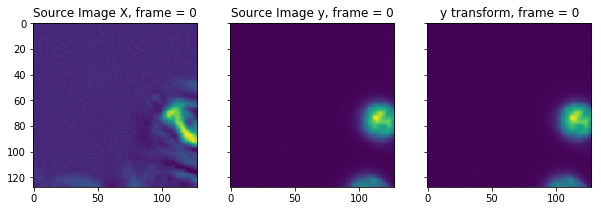

In [6]:
y_transform = test_none_transform()
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 10), sharex=True, sharey=True)

ax = axes.ravel()

X_temp = train_dict['X'][:1]
y_temp = train_dict['y'][:1]

ax[0].imshow(X_temp[0, 0, ..., 0])
ax[0].set_title('Source Image X, frame = 0')

ax[1].imshow(y_temp[0, ..., 0])
ax[1].set_title('Source Image y, frame = 0')

ax[2].imshow(y_transform[0, ..., 0])
ax[2].set_title('y transform, frame = 0')

plt.show()

### Training params

In [40]:
dapi_model_name = 'dapi_model'

n_epoch = 5  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'whole_image'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 3  # FC training uses 1 image per batch

# Transformation settings
transform = "centroid"
dilation_radius = 1  # change dilation radius for edge dilation

# 3D Settings
frames_per_batch = 61
# norm_method = None #'whole_image'

# Model

In [36]:
from tensorflow.python.keras.layers import Lambda, Reshape
import tensorflow as tf
    
def feature_net_3D(receptive_field=61,
                    n_frames=3,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    # n_dense_filters=200,
                    n_dense_filters=64,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='whole_image',
                    gru=False,
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=False):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    win_z = (n_frames - 1) // 2

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method, filter_size=receptive_field)(x[-1]))
    # x.append(BatchNormalization(axis=channel_axis)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))([-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    if multires:
        layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    append_gru = False
    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size), 
                        dilation_rate=(1, d, d), kernel_initializer=init,
                        padding='valid', kernel_regularizer=l2(reg))(x[-1]))

        
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d), pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))
        
    
    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d), kernel_initializer=init, padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    x.append(TensorProduct(n_dense_filters, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

#     x.append(TensorProduct(1, kernel_initializer=init, kernel_regularizer=l2(reg))(x[-1]))
#     x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    
    x.append(Conv3D(1, kernel_size=(61, 1, 1), padding='valid')(x[-1]))
            
    if not dilated:
        x.append(Flatten()(x[-1]))
        
    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))
    
#     x.append(Lambda(lambda x: x[:,0,...])(x[-1]))
    x.append(Lambda(lambda x: tf.squeeze(x, 1))(x[-1]))
    # x.append(Reshape(tuple(input_shape[1:]))(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()

    return model

In [37]:
from tensorflow.python.keras.layers import Lambda

def image_norm(inputs):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    axes = [3, 4] if channel_axis == 1 else [2, 3]
    output = inputs - K.mean(inputs, axis=axes, keepdims=True)
    output = output / K.std(inputs, axis=axes, keepdims=True)
    return output

def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    # print(K.image_data_format())
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    inputs = Input(shape=input_shape)
    
    img = Lambda(image_norm)(inputs)
    #img = BatchNormalization(axis=channel_axis)(inputs)

    models = []
    model_outputs = []

    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img
        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, norm_method=None, dilated=True, 
                                     padding=True, padding_mode=padding_mode, **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    else:
        if fgbg_model is None:
            model = Model(inputs=inputs, outputs=model_outputs)
        else:
            model = Model(inputs=inputs, outputs=model_outputs[1:])
    model.summary()
    return model

# Train

In [38]:
def train_model_conv(model,
                     #dataset,
                     train_dict,
                     test_dict,
                     expt='',
                     test_size=.1,
                     n_epoch=10,
                     batch_size=1,
                     num_gpus=None,
                     frames_per_batch=5,
                     transform=None,
                     optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
                     log_dir='/data/tensorboard_logs',
                     model_dir='/data/models',
                     model_name=None,
                     focal=False,
                     gamma=0.5,
                     lr_sched=rate_scheduler(lr=0.01, decay=0.95),
                     rotation_range=0,
                     flip=True,
                     shear=0,
                     zoom_range=0,
                     seed=None,
                     **kwargs):
    is_channels_first = K.image_data_format() == 'channels_first'

    if model_name is None:
        todays_date = datetime.datetime.now().strftime('%Y-%m-%d')
        data_name = os.path.splitext(os.path.basename(dataset))[0]
        model_name = '{}_{}_{}'.format(todays_date, data_name, expt)
    model_path = os.path.join(model_dir, '{}.h5'.format(model_name))
    loss_path = os.path.join(model_dir, '{}.npz'.format(model_name))
    
    # train_dict, test_dict = get_data(dataset, mode='conv', test_size=test_size)

    n_classes = model.layers[-1].output_shape[1 if is_channels_first else -1]
    # the data, shuffled and split between train and test sets
    print('X_train shape:', train_dict['X'].shape)
    print('y_train shape:', train_dict['y'].shape)
    print('X_test shape:', test_dict['X'].shape)
    print('y_test shape:', test_dict['y'].shape)
    print('Output Shape:', model.layers[-1].output_shape)
    print('Number of Classes:', n_classes)

#     def loss_function(y_true, y_pred):
#         if isinstance(transform, str) and transform.lower() == 'disc':
#             return losses.discriminative_instance_loss(y_true, y_pred)
#         if focal:
#             return losses.weighted_focal_loss(
#                 y_true, y_pred, gamma=gamma, n_classes=n_classes)
#         return losses.weighted_categorical_crossentropy(
#             y_true, y_pred, n_classes=n_classes, from_logits=False)

    if num_gpus is None:
        num_gpus = train_utils.count_gpus()

    if num_gpus >= 2:
        batch_size = batch_size * num_gpus
        model = train_utils.MultiGpuModel(model, num_gpus)

    print('Training on {} GPUs'.format(num_gpus))

    # model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
    
    run_options = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    model.compile(loss=mean_squared_error, optimizer=optimizer, metrics=['accuracy'])

    if isinstance(model.output_shape, list):
        skip = len(model.output_shape) - 1
    else:
        skip = None

    if train_dict['X'].ndim == 4:
        DataGenerator = image_generators.ImageFullyConvDataGenerator
    elif train_dict['X'].ndim == 5:
        DataGenerator = stack_generator.StackDataGenerator
    else:
        raise ValueError('Expected `X` to have ndim 4 or 5. Got',
                         train_dict['X'].ndim)

    if num_gpus >= 2:
        # Each GPU must have at least one validation example
        if test_dict['y'].shape[0] < num_gpus:
            raise ValueError('Not enough validation data for {} GPUs. '
                             'Received {} validation sample.'.format(
                                 test_dict['y'].shape[0], num_gpus))

        # When using multiple GPUs and skip_connections,
        # the training data must be evenly distributed across all GPUs
        num_train = train_dict['y'].shape[0]
        nb_samples = num_train - num_train % batch_size
        if nb_samples:
            train_dict['y'] = train_dict['y'][:nb_samples]
            train_dict['X'] = train_dict['X'][:nb_samples]

    # this will do preprocessing and realtime data augmentation
    datagen = DataGenerator(
        rotation_range=rotation_range,
        shear_range=shear,
        zoom_range=zoom_range,
        horizontal_flip=flip,
        vertical_flip=flip)

    datagen_val = DataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0)

    if train_dict['X'].ndim == 5:
        train_data = datagen_val.flow(
            train_dict,
            skip=skip,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs,
            frames_per_batch=frames_per_batch)

        val_data = datagen_val.flow(
            test_dict,
            skip=skip,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs,
            frames_per_batch=frames_per_batch)
    else:
        train_data = datagen.flow(
            train_dict,
            skip=skip,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs)

        val_data = datagen_val.flow(
            test_dict,
            skip=skip,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=kwargs)
        
    # Check memory leaks
#     all_objects = muppy.get_objects()
#     sum1 = summary.summarize(all_objects)
#     summary.print_(sum1)

    # fit the model on the batches generated by datagen.flow()
    loss_history = model.fit_generator(
        train_data,
        steps_per_epoch=train_data.y.shape[0] // batch_size,
        epochs=n_epoch,
        validation_data=val_data,
        validation_steps=val_data.y.shape[0] // batch_size,
        callbacks=[
            callbacks.LearningRateScheduler(lr_sched),
            callbacks.ModelCheckpoint(
                model_path, monitor='val_loss', verbose=1,
                save_best_only=True, save_weights_only=num_gpus >= 2),
            callbacks.TensorBoard(log_dir=os.path.join(log_dir, model_name))
        ])

    model.save_weights(model_path)
    np.savez(loss_path, loss_history=loss_history.history)

    return model

In [41]:
from tensorflow.python.keras.optimizers import Adam, Nadam

dapi_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(dapi_model_name))


dapi_model = feature_net_3D(
        receptive_field=receptive_field,
        n_features=1,
        n_frames=frames_per_batch,
        dilated=True, 
        # padding=True,
        # n_skips=n_skips,
        n_conv_filters=2,
        n_dense_filters=8,
        input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
        #multires=False,
        #last_only=False,
        norm_method=norm_method)
# dapi_model.load_weights(dapi_weights_file)


dapi_model = train_model_conv(
    model=dapi_model,
    train_dict=train_dict,
    test_dict=test_dict,
    model_name=dapi_model_name,
    test_size=test_size,
    n_epoch=n_epoch,
    batch_size=batch_size,
    optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#     optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
    frames_per_batch=frames_per_batch,
    transform=transform,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 61, 128, 128, 1)   0         
_________________________________________________________________
image_normalization3d_10 (Im (None, 61, 128, 128, 1)   226981    
_________________________________________________________________
reflection_padding3d_10 (Ref (None, 121, 188, 188, 1)  0         
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 121, 185, 185, 2)  34        
_________________________________________________________________
batch_normalization_v1_90 (B (None, 121, 185, 185, 2)  8         
_________________________________________________________________
activation_90 (Activation)   (None, 121, 185, 185, 2)  0         
_________________________________________________________________
conv3d_91 (Conv3D)           (None, 121, 183, 183, 2)  38        
__________

NotImplementedError: `centroid` transform has not been finished

In [21]:
dapi_model.save_weights(dapi_weights_file)


# Test Images

In [22]:
# print(tuple(test_dict['X'].shape[1:]))
run_dapi_model = feature_net_3D(
    receptive_field=receptive_field,
    n_features=1,
    n_frames=frames_per_batch,
    dilated=True, 
    n_conv_filters=2,
    n_dense_filters=8,
    input_shape=tuple(test_dict['X'].shape[1:]),
#     multires=False,
#     last_only=False,
    norm_method=norm_method)
run_dapi_model.load_weights(dapi_weights_file)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 61, 128, 128, 1)   0         
_________________________________________________________________
image_normalization3d_5 (Ima (None, 61, 128, 128, 1)   226981    
_________________________________________________________________
reflection_padding3d_5 (Refl (None, 121, 188, 188, 1)  0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 121, 185, 185, 2)  34        
_________________________________________________________________
batch_normalization_v1_45 (B (None, 121, 185, 185, 2)  8         
_________________________________________________________________
activation_45 (Activation)   (None, 121, 185, 185, 2)  0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 121, 183, 183, 2)  38        
__________

# Predict

In [23]:
test_images = dapi_model.predict(test_dict['X'])

print('segmentation mask shape:', test_images.shape)

segmentation mask shape: (76, 128, 128, 1)


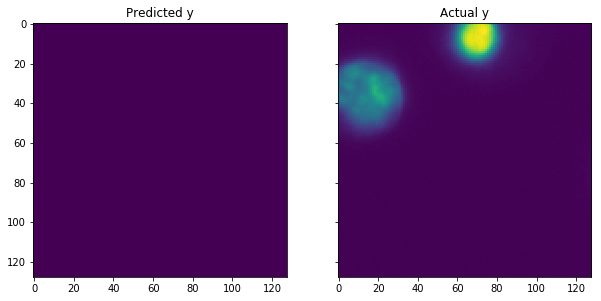

In [24]:

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 10), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(test_images[7, :, :, 0])
ax[0].set_title('Predicted y')

ax[1].imshow(test_dict['y'][7, :, :, 0])
ax[1].set_title('Actual y')

plt.show()
